In [1]:
import traceback
import segmentation_models as sm
from tensorflow import keras
import loadData
#from tf_processe_data import display_sample
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model

2022-03-27 19:21:33.958509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpf/tools/centos7/tcltk/8.6.11/lib:/hpf/tools/centos6/gdal/2.4.0/lib/:/hpf/tools/centos6/netcdf/4.3.2/lib/:/hpf/tools/centos6/libtiff/4.0.9/lib/:/hpf/tools/centos7/sqlite/3.35.3/lib:/hpf/tools/centos7/proj/7.2.0/lib:/hpf/tools/centos6/geos/3.4.2/lib:/hpf/tools/centos6/libpng/1.2.59/lib/:/hpf/tools/centos7/udunits2/2.2.28/lib:/hpf/tools/centos7/hdf5/1.10.5/lib:/hpf/tools/centos7/R/4.0.4_pbalin/lib64:/hpf/tools/centos7/pcre/8.44.utf8/lib:/hpf/tools/centos7/libxml2/2.9.1/lib64:/hpf/tools/centos7/curl/7.74.0/lib:/hpf/tools/centos7/readline/8.1/lib:/hpf/tools/centos6/gcc/7.2.0/lib64/:/hpf/tools/centos6/gcc/7.2.0/lib/:/hpf/tools/centos7/python/3.9.2_pbalin/lib:/hpf/largeprojects/tabori/shared/software/lib:/usr/lib64/
2022-03-27 19:21:33.958544: I 

Segmentation Models: using `keras` framework.
ok


In [2]:
sm.set_framework('tf.keras')
sm.framework()
#define model
BACKBONE = 'vgg19'
BATCH_SIZE = 8
TRAIN_SIZE = 141
VAL_SIZE = 10
CLASSES = ['NCI', 'GCI','_background_']
LR = 0.00001

preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights=None,classes=3, activation='softmax',input_shape=(None, None, 3),encoder_freeze=True)
model.load_weights('tuning_model_000_newbase.h5')
#optim = keras.optimizers.Adam(LR)
#metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
#loss_funcs = sm.losses.DiceLoss(class_weights=np.array([1, 1, 1.1])) + (1*sm.losses.CategoricalFocalLoss())
# #loss_funcs = sm.losses.CategoricalCELoss
#model.compile(optim, loss_funcs, metrics)
#model.compile()
# model.summary()

2022-03-27 19:21:58.286091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpf/tools/centos7/tcltk/8.6.11/lib:/hpf/tools/centos6/gdal/2.4.0/lib/:/hpf/tools/centos6/netcdf/4.3.2/lib/:/hpf/tools/centos6/libtiff/4.0.9/lib/:/hpf/tools/centos7/sqlite/3.35.3/lib:/hpf/tools/centos7/proj/7.2.0/lib:/hpf/tools/centos6/geos/3.4.2/lib:/hpf/tools/centos6/libpng/1.2.59/lib/:/hpf/tools/centos7/udunits2/2.2.28/lib:/hpf/tools/centos7/hdf5/1.10.5/lib:/hpf/tools/centos7/R/4.0.4_pbalin/lib64:/hpf/tools/centos7/pcre/8.44.utf8/lib:/hpf/tools/centos7/libxml2/2.9.1/lib64:/hpf/tools/centos7/curl/7.74.0/lib:/hpf/tools/centos7/readline/8.1/lib:/hpf/tools/centos6/gcc/7.2.0/lib64/:/hpf/tools/centos6/gcc/7.2.0/lib/:/hpf/tools/centos7/python/3.9.2_pbalin/lib:/hpf/largeprojects/tabori/shared/software/lib:/usr/lib64/
2022-03-27 19:21:58.286125: W tensorflow

In [3]:
#visulize and save model 

#plot_model(model, to_file='model_plot.png', show_shapes=True,expand_nested=False,rankdir="TB",dpi=300,show_layer_names=True,show_layer_activations=True)

model.save('finalmodel_newbase_000.h5')

In [4]:
x_train,y_train = loadData.load_data()
x_train_pp = preprocess_input(x_train)
y_train = y_train.astype('float32')
y_train = y_train/2

x_test = loadData.load_test()
x_test_pp = preprocess_input(x_test)

In [58]:
def threshold(fig_raw,nci,gci):
    fig=fig_raw.copy()
    fig0=fig[...,0].flatten()
    fig1=fig[...,1].flatten()
    fig2=fig[...,2].flatten()
    for i in range(len(fig0)):
        if fig0[i]<nci:
            fig0[i]=0
        elif fig0[i]>nci:
            fig0[i]=1
        if fig1[i]<gci:
            fig1[i]=0
        elif fig1[i]>gci:
            fig1[i]=1
        if (fig0[i]>=nci or fig1[i]>=gci):
            fig2[i]=0
        if (fig0[i]<nci and fig1[i]<gci):
            fig2[i]=1
    fig[...,0]=np.reshape(fig0,np.shape(fig[...,0]))
    fig[...,1]=np.reshape(fig1,np.shape(fig[...,0]))
    fig[...,2]=np.reshape(fig2,np.shape(fig[...,0]))
    return fig

(-0.5, 255.5, 255.5, -0.5)

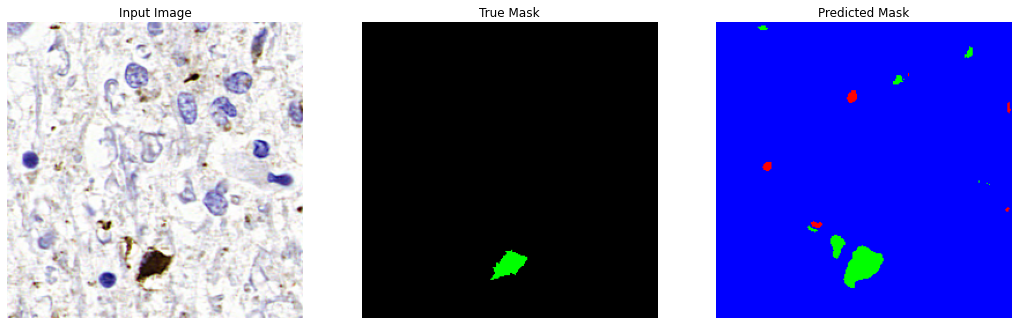

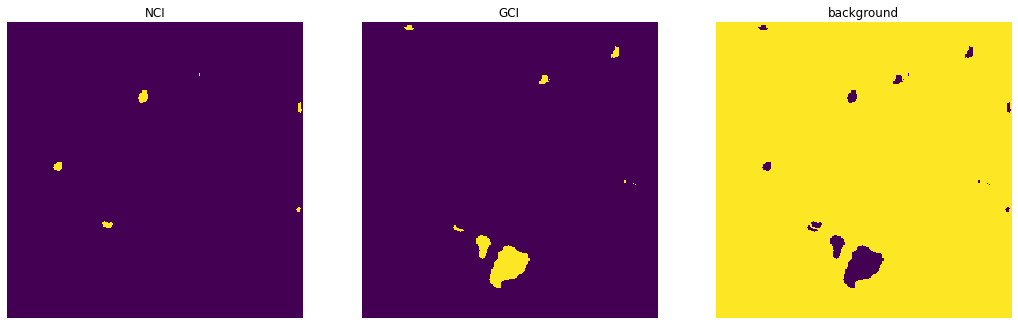

In [80]:
#save prediction
i=15

pr_mask = model.predict(np.expand_dims(x_train_pp[i],axis=0))
pr_mask=threshold(pr_mask,0.995,0.995)

loadData.display_sample([x_train[i], y_train[i],np.squeeze(pr_mask, axis=0)],'tuning_model.png')



#plot the masks
pred=np.squeeze(pr_mask, axis=0)
fig,ax=plt.subplots(figsize=(18,18))
ax1=plt.subplot(131)
ax1.imshow(pred[...,0], interpolation='nearest')
ax1.set_title('NCI')
plt.axis('off')
ax2=plt.subplot(132)
ax2.imshow(pred[...,1], interpolation='nearest')
ax2.set_title('GCI')
plt.axis('off')
ax3=plt.subplot(133)
ax3.imshow(pred[...,2], interpolation='nearest')
ax3.set_title('background')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

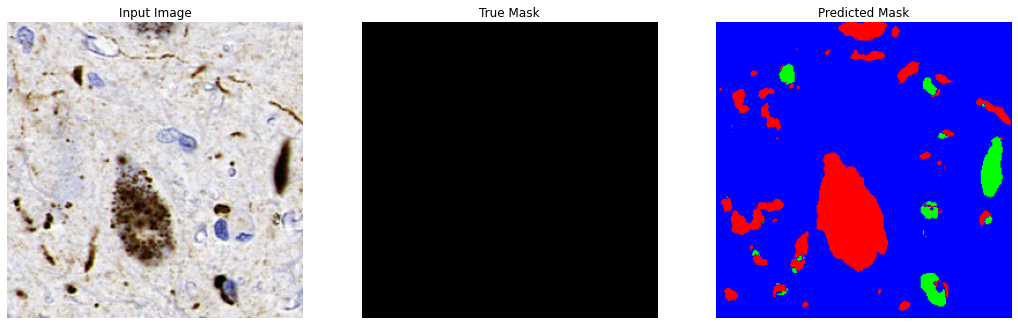

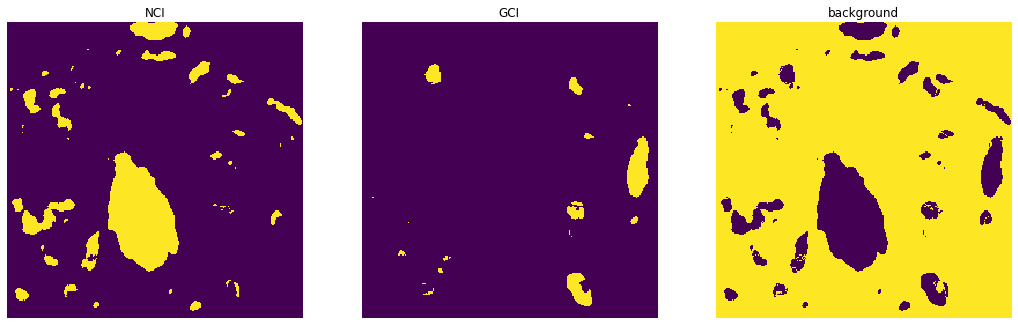

In [88]:
#save prediction
#i=14
i=9
pr_mask = model.predict_on_batch(np.expand_dims(x_test_pp[i],axis=0))
pr_mask=threshold(pr_mask,0.6,0.6)

loadData.display_sample([x_test[i], np.zeros((256,256,3)),np.squeeze(pr_mask, axis=0)],'tuning_model.png')

#plot the masks
pred=np.squeeze(pr_mask, axis=0)
fig,ax=plt.subplots(figsize=(18,18))
ax1=plt.subplot(131)
ax1.imshow(pred[...,0], interpolation='nearest')
ax1.set_title('NCI')
plt.axis('off')
ax2=plt.subplot(132)
ax2.imshow(pred[...,1], interpolation='nearest')
ax2.set_title('GCI')
plt.axis('off')
ax3=plt.subplot(133)
ax3.imshow(pred[...,2], interpolation='nearest')
ax3.set_title('background')
plt.axis('off')

In [8]:
model.evaluate(x_train,y_train):

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [62]:
pr_all = model.predict(x_train_pp)

In [67]:
for i in range(len(pr_all)):
    pr_all[i]=threshold(pr_all[i],0.995,0.995)

In [68]:
from sklearn.metrics import accuracy_score,f1_score,adjusted_mutual_info_score
print(f'acc={accuracy_score((y_train/64).flatten().astype(int),pr_all.flatten())}')
# print(f'f1={f1_score((y_train/64).flatten().astype(int),pr_all.flatten().astype(int))}')  
# print(f'ami={adjusted_mutual_info_score((y_train/64).flatten().astype(int),pr_all.flatten().astype(int))}')  

acc=0.6793139796646489


In [65]:
print(np.unique((y_train/64).flatten()))
print(np.unique(pr_all.flatten()))

[0. 1.]
[0. 1.]
